# База знань про мови

Цей інтерактивний документ Jupyter призначений для роботи з базою знань. Користувач може переглядати факти бази знань у вигляді таблиці або графа, створювати запити до бази знань, додавати (або видаляти) факти вручну або шляхом застосування механізму логічного виведення.

База знань складається з множини фактів і множини правил логічного виведення. Факти бази знань подані як триплети (суб'єкт, предикат, об'єкт) або (s, p, o). Триплети зберігаються у файлі формату CSV. Для зручного оброблення за допомогою пакету pandas ці триплети завантажуються в таблицю df (DataFrame).

Віджети IPyWidgets (текстові поля і кнопки) дозволяють інтерактивну роботу з БЗ - пошук триплетів за шаблоном, додавання нових триплетів та їх видалення.

Для візуалізації графа бази знань використовуються пакети NetworkX (створює граф) та Matplotlib (візуалізує граф). NetworkX також можна використати для застосування різноманітних алгоритмів на графах.

Правила і машина виведення описані в модулі example3. Правила логічного виведення (rule1, rule2) дозволяють виводити нові факти за допомогою машини логічного виведення (reasoner). Машина виведення виконує "пряме виведення" та використовує підхід "а-ля RETE" для пришвидшення алгоритму, тобто будує дерево триплетів для швидкого пошуку.

Послідовність запуску через JupyterLite:

1. Відкрийте в браузері https://jupyter.org/try-jupyter/lab/
2. Перетягніть у File Browser (зліва) файли TextSelectInteractKB.ipynb, kb.csv, mykb.py, example3.py
3. Запустіть TextSelectInteractKB.ipynb і виконайте усі комірки

In [41]:
import textwrap
import networkx as nx
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import pandas

In [42]:
# імпортуємо таблицю з фактами бази знань (s, p, o)
df = pandas.read_csv('kb.csv')
df

,s,p,o
0,українська,родина,індоєвропейська
1,українська,типологія,флективна
2,українська,письмо,кирилиця
3,українська,поширення,Європа
4,українська,статус,офіційна
...,...,...,...
184,навахо,письмо,латиниця
185,навахо,поширення,Америка
186,навахо,статус,регіональна
187,навахо,особливість,тональна мова


In [43]:
# приклад запиту до бази знань:
# вивести таблицю усіх фактів (s, p, o), де s містить "німецька"
df[
    df["s"].str.contains("німецька")
]

,s,p,o
15,німецька,родина,індоєвропейська
16,німецька,типологія,флективна
17,німецька,письмо,латиниця
18,німецька,поширення,Європа
19,німецька,статус,офіційна
20,німецька,особливість,наявність трьох родів


In [44]:
# вивести таблицю усіх фактів (s, p, o), де s містить "німецька" і p містить "поширення"
df[
    df["s"].str.contains("німецька") &
    df["p"].str.contains("поширення")
]

,s,p,o
18,німецька,поширення,Європа


In [45]:
output_table = ipywidgets.Output()
def f1(b):
    global fdf
    with output_table:
        output_table.clear_output(wait=True)
        fdf = df[
            df["s"].str.contains(s.value, case=False, na=False) &
            df["p"].str.contains(p.value, case=False, na=False) &
            df["o"].str.contains(o.value, case=False, na=False)
        ]
        display(fdf)
        print(f"Знайдено {len(fdf)} фактів.")

In [46]:
output_log = ipywidgets.Output()
def on_button_clicked(b):
    global df
    ndf = pandas.DataFrame([[s.value, p.value, o.value]], columns=["s", "p", "o"])
    if b.description == "Add to KB":
        df = pandas.concat([df, ndf], ignore_index=True)
    elif b.description == "Remove from KB":
        df = pandas.concat([df, ndf], ignore_index=True).drop_duplicates(keep=False, ignore_index=True)
    df.to_csv("kb.csv", index=False)
    with output_log:
        output_log.clear_output(wait=True)
        print(f"{b.description}: ({s.value}, {p.value}, {o.value})")
    f1(button_search)  # оновити таблицю після змін

In [ ]:
s = ipywidgets.Text(description="Суб'єкт:", placeholder="Введіть назву мови...")

predicates = sorted(df["p"].dropna().unique().tolist())
predicates = [""] + predicates
p = ipywidgets.Dropdown(options=predicates, description="Предикат:")

o = ipywidgets.Text(description="Об'єкт:", placeholder="Введіть характеристику...")

# --- кнопки ---
button_search = ipywidgets.Button(description="Search KB")
button_add = ipywidgets.Button(description="Add to KB", button_style="success")
button_remove = ipywidgets.Button(description="Remove from KB", button_style="danger")

button_search.on_click(f1)
button_add.on_click(on_button_clicked)
button_remove.on_click(on_button_clicked)

# --- компонування інтерфейсу ---
controls = ipywidgets.VBox([s, p, o])
buttons = ipywidgets.HBox([button_search, button_add, button_remove])
ui = ipywidgets.VBox([controls, buttons, output_log, output_table])

display(ui)
f1(button_search)

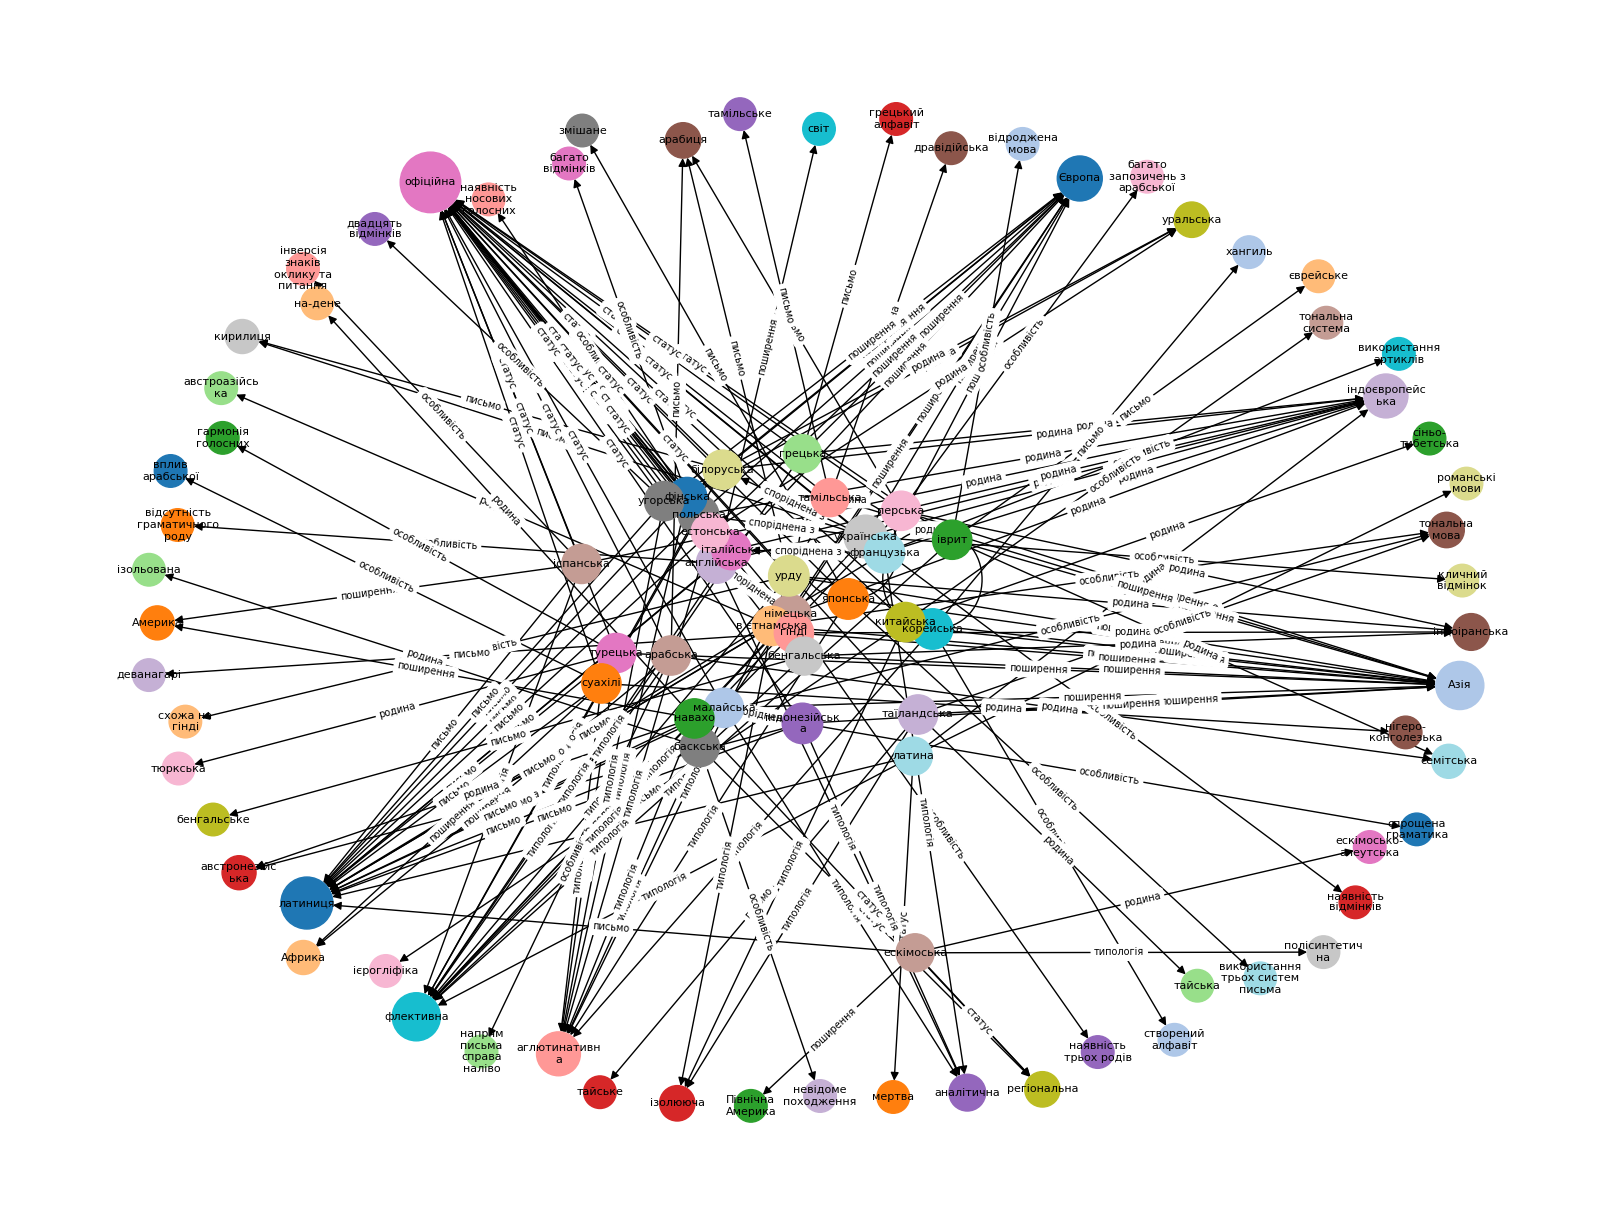

In [48]:
# створення графа
G = nx.DiGraph()
for r in fdf.itertuples():
    s_label = textwrap.fill(r.s, width=12)
    o_label = textwrap.fill(r.o, width=12)
    G.add_edge(s_label, o_label, label=r.p)
# Отримуємо унікальні вузли
nodes = list(G.nodes())
unique_nodes = sorted(set(nodes))
# Створюємо кольорову палітру з matplotlib
cmap = plt.colormaps.get_cmap('tab20')
# Присвоюємо кольори вузлам
color_map = {node: cmap(i % 20) for i, node in enumerate(unique_nodes)}  # повторюємо палітру, якщо вузлів >20
node_colors = [color_map[n] for n in nodes]
# --- Розмір вузлів пропорційно ступеню ---
node_size = [500 + 50*G.degree(n) for n in G.nodes()]
# --- Позиції (spring layout) ---
pos = nx.spring_layout(G, k=0.5, iterations=100, weight='weight', seed=42)
# --- Малювання ---
plt.figure(figsize=(16,12))
nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_colors,
        font_size=8, arrowsize=12)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.axis('off')
plt.show()

In [49]:
# імпорт правил і машини логічного виведення з модуля example3
from example3 import *

In [50]:
# наповнити множину F усіма фактами
F=set()
for row in df.itertuples():
    F.add((row.s, row.p, row.o))
# вивести нові факти за правилами rule1, rule2
A=reasoner(F, [rule1, rule2], ["родина"], ["поширення"])
print(A) # усі факти
print(A-F) # нові факти

{('баскська', 'письмо', 'латиниця'), ('навахо', 'письмо', 'латиниця'), ('Азія', 'поширення', 'перська'), ('латина', 'письмо', 'латиниця'), ('французька', 'особливість', 'використання артиклів'), ('тамільська', 'родина', 'дравідійська'), ('угорська', 'письмо', 'латиниця'), ('в’єтнамська', 'типологія', 'ізолююча'), ('бенгальська', 'письмо', 'бенгальське'), ('індонезійська', 'письмо', 'латиниця'), ('іспанська', 'типологія', 'флективна'), ('Європа', 'поширення', 'угорська'), ('японська', 'письмо', 'змішане'), ('фінська', 'поширення', 'Європа'), ('бенгальська', 'родина', 'індоіранська'), ('білоруська', 'типологія', 'флективна'), ('гінді', 'письмо', 'деванагарі'), ('грецька', 'статус', 'офіційна'), ('іврит', 'поширення', 'Азія'), ('урду', 'родина', 'індоіранська'), ('Азія', 'поширення', 'китайська'), ('іврит', 'типологія', 'флективна'), ('німецька', 'особливість', 'наявність трьох родів'), ('ескімоська', 'родина', 'ескімосько-алеутська'), ('баскська', 'статус', 'регіональна'), ('українська',